In [12]:
!pip install tensorflow keras


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Activation, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the paths to your datasets
train_data_dir = '/content/drive/MyDrive/dataset_path/dataset_path/train'
validation_data_dir = '/content/drive/MyDrive/dataset_path/dataset_path/val'
test_data_dir = '/content/drive/MyDrive/dataset_path/dataset_path/test'

# Image dimensions
img_height, img_width = 224, 224
batch_size = 5

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define SqueezeNet architecture with enhancements
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'
    x = Conv2D(squeeze, (1, 1), padding='valid', name=s_id + 'squeeze1x1')(x)
    x = Activation('relu', name=s_id + 'relu_squeeze1x1')(x)

    left = Conv2D(expand, (1, 1), padding='valid', name=s_id + 'expand1x1')(x)
    left = Activation('relu', name=s_id + 'relu_expand1x1')(left)

    right = Conv2D(expand, (3, 3), padding='same', name=s_id + 'expand3x3')(x)
    right = Activation('relu', name=s_id + 'relu_expand3x3')(right)

    x = concatenate([left, right], axis=3, name=s_id + 'concat')
    return x

input_img = Input(shape=(img_height, img_width, 3))
x = Conv2D(96, (7, 7), strides=(2, 2), padding='valid', name='conv1')(input_img)
x = BatchNormalization()(x)
x = Activation('relu', name='relu_conv1')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1')(x)

x = fire_module(x, fire_id=2, squeeze=16, expand=64)
x = BatchNormalization()(x)
x = fire_module(x, fire_id=3, squeeze=16, expand=64)
x = BatchNormalization()(x)
x = fire_module(x, fire_id=4, squeeze=32, expand=128)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(x)

x = fire_module(x, fire_id=5, squeeze=32, expand=128)
x = BatchNormalization()(x)
x = fire_module(x, fire_id=6, squeeze=48, expand=192)
x = BatchNormalization()(x)
x = fire_module(x, fire_id=7, squeeze=48, expand=192)
x = BatchNormalization()(x)
x = fire_module(x, fire_id=8, squeeze=64, expand=256)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool8')(x)

x = fire_module(x, fire_id=9, squeeze=64, expand=256)
x = BatchNormalization()(x)
x = Dropout(0.5, name='dropout9')(x)
x = Conv2D(train_generator.num_classes, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
out = Activation('softmax', name='softmax')(x)

model = Model(input_img, out, name='squeezenet')

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.00001)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=200,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Evaluate the model on the test set
model.load_weights('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_accuracy:.2f}')

# Save the model
model.save('squeezenet_face_recognition.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('squeezenet_face_recognition.tflite', 'wb') as f:
    f.write(tflite_model)



Found 322 images belonging to 54 classes.
Found 55 images belonging to 54 classes.
Found 54 images belonging to 54 classes.
Epoch 1/200
64/64 [==============================] - 16s 94ms/step - loss: 3.9685 - accuracy: 0.0221 - val_loss: 4.0133 - val_accuracy: 0.0182 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
64/64 [==============================] - 5s 85ms/step - loss: 3.8826 - accuracy: 0.0568 - val_loss: 4.0547 - val_accuracy: 0.0182 - lr: 1.0000e-04
Epoch 3/200
64/64 [==============================] - 6s 86ms/step - loss: 3.8105 - accuracy: 0.0631 - val_loss: 4.1131 - val_accuracy: 0.0182 - lr: 1.0000e-04
Epoch 4/200
64/64 [==============================] - 6s 86ms/step - loss: 3.7361 - accuracy: 0.0473 - val_loss: 4.1852 - val_accuracy: 0.0182 - lr: 1.0000e-04
Epoch 5/200
64/64 [==============================] - 6s 86ms/step - loss: 3.5742 - accuracy: 0.0820 - val_loss: 4.1400 - val_accuracy: 0.0182 - lr: 1.0000e-04
Epoch 6/200
64/64 [==============================] - 5s 85ms/step - loss: 3.5372 - accuracy: 0.0599 - val_loss: 4.1531 - val_accuracy: 0.0182 - lr: 1.0000e-04
Epoch 7/200
64/64 [==============================] - 6s 87ms/step - loss: 3.4280 - accuracy: 0.0442 - val_loss: 4.0181 - val_accuracy: 0.0364 - lr: 1.0000e-04
Epoch 8/200
64/64 [===========================

In [20]:
!pip install seaborn scikit-learn


11/11 [==============================] - 1s 42ms/step


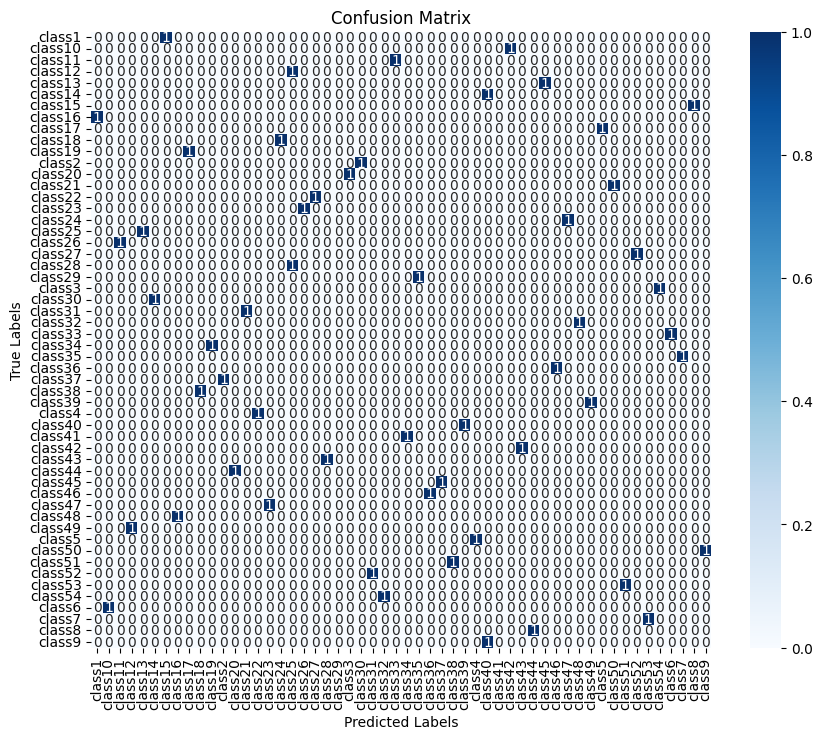

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model

# Load the best model
model = load_model('best_model.h5')

# Generate predictions
steps = test_generator.samples // test_generator.batch_size + (1 if test_generator.samples % test_generator.batch_size != 0 else 0)
y_pred = model.predict(test_generator, steps=steps)
y_true = test_generator.classes

# Ensure the number of predictions matches the number of samples
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_true[:len(y_pred_classes)]

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




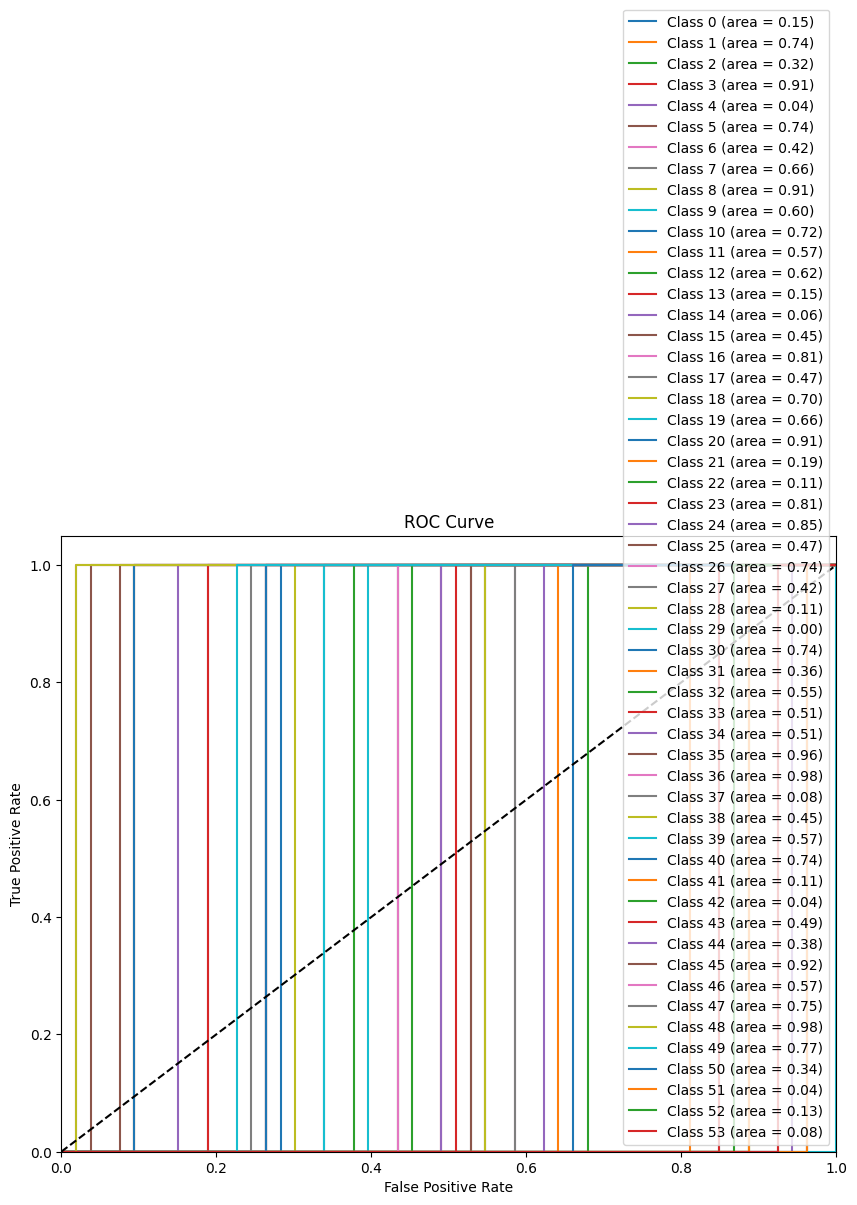

In [23]:
# Plot ROC curve
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i in range(len(test_generator.class_indices)):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [24]:
# Save the model
model.save('squeezenet_face_recognition.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('squeezenet_face_recognition.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
